In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from llama_index.llms.azure_openai import AzureOpenAI

api_key=os.getenv("AZURE_OPENAI_KEY")
api_version="2024-02-15-preview"
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
model = "gpt-35-turbo"
deployment_name = "gpt-35-turbo"

class LLM(AzureOpenAI):
    def __init__(self):
        super().__init__(
            model=deployment_name,
            deployment_name=deployment_name,
            api_key=api_key,
            azure_endpoint=azure_endpoint,
            api_version=api_version,
            temperature=0.0
        )
llm = LLM()

from lavague.defaults import DefaultEmbedder

embedder = DefaultEmbedder()

/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from lavague.action_engine import ActionEngine

action_engine = ActionEngine(llm, embedder)

In [8]:
from lavague.defaults import evaluation_get_selenium_driver

get_driver = evaluation_get_selenium_driver
lavague_driver = get_driver()
_, driver = lavague_driver.getDriver()

In [9]:
import pandas as pd 
from datasets import load_dataset

dataset = load_dataset("BigAction/the-wave-clean")

df = dataset["train"].to_pandas()
df.head(5)

,query,url,html,selenium_ground_truth,ground_truth_outer_html,ground_truth_highlighted_screenshot
0,click on create account,https://en.wikipedia.org/wiki/Main_Page,"<html class=""client-js vector-feature-language...",create_account_link = driver.find_element(By.X...,"<li id=""pt-createaccount-2"" class=""user-links-...",iVBORw0KGgoAAAANSUhEUgAABkAAAAOECAYAAAD5Tf2iAA...
1,click on past,https://news.ycombinator.com/,"<html lang=""en"" op=""news""><head><meta name=""re...",link_to_click = driver.find_element(By.LINK_TE...,"<a href=""front"">past</a>",iVBORw0KGgoAAAANSUhEUgAABkAAAAOECAYAAAD5Tf2iAA...
2,click on pricing,https://www.perfagents.com/,"<html lang=""en""><head>\n <meta charset=""utf...","pricing_link = driver.find_element(By.XPATH, ""...","<a class=""font-medium px-3 lg:px-5 py-2 items-...",iVBORw0KGgoAAAANSUhEUgAABkAAAAOECAYAAAD5Tf2iAA...
3,click on SPF Justice,https://justice.belgium.be/fr,"<html lang=""fr"" dir=""ltr"" prefix=""content: htt...",spf_justice_link = driver.find_element(By.XPAT...,<span>SPF Justice</span>,iVBORw0KGgoAAAANSUhEUgAABkAAAAOECAYAAAD5Tf2iAA...
4,click on Search,https://www.cancer.gov/publications/dictionari...,"<html lang=""en"" dir=""ltr"" prefix=""og: https://...","search_button = driver.find_element(By.XPATH, ...","<input type=""submit"" class=""submit button post...",iVBORw0KGgoAAAANSUhEUgAABkAAAAOECAYAAAD5Tf2iAA...


In [25]:
from lavague.evaluator import SeleniumActionEvaluator

column_mapping = {"query": "query", "html": "html", "ground_truth_code": "selenium_ground_truth"}

evaluator = SeleniumActionEvaluator(driver, action_engine)
results = evaluator.evaluate_df(df)
results

/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
/home/daniel/miniconda3/envs/lavague/lib/python3.10/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new),

,recall_retriever,precision_retriever,recall_llm,precision_llm,valid_generated_code
0,1.000000,0.083333,0.000000,0.0,Message: no such element: Unable to locate ele...
1,1.000000,0.030303,1.000000,1.0,Yes
2,1.000000,0.050000,1.000000,1.0,Yes
3,1.000000,0.041667,0.000000,0.0,Message: no such element: Unable to locate ele...
4,0.000000,0.000000,1.000000,1.0,Yes
5,1.000000,0.050000,1.000000,1.0,Yes
6,1.000000,0.037037,1.000000,1.0,Yes
7,1.000000,0.035714,1.000000,1.0,Yes
8,0.000000,0.000000,1.000000,1.0,Yes
9,0.000000,0.000000,1.000000,1.0,Yes


In [28]:
results.drop("valid_generated_code", axis=1).mean()

recall_retriever       0.787255
precision_retriever    0.119181
recall_llm             0.721667
precision_llm          0.760000
dtype: float64

In [29]:
(results.recall_retriever == 1.0).mean()

0.74

<Axes: >

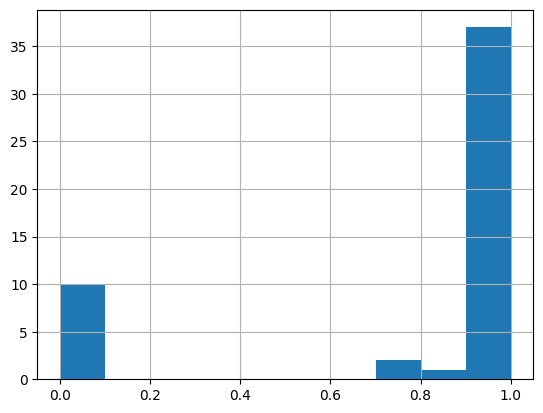

In [30]:
results.recall_retriever.hist()

In [31]:
(results.recall_llm == 1.0).mean()

0.7

LLM recall when retriever is right: 0.7567567567567568


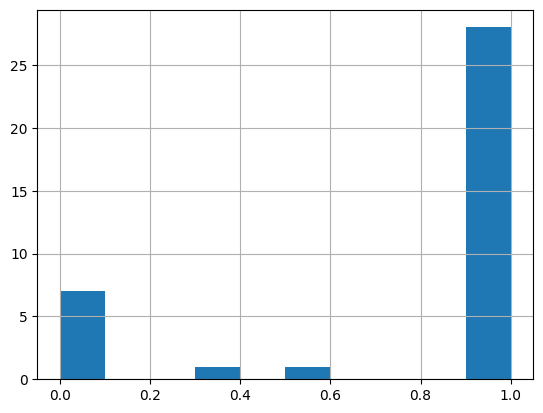

In [32]:
right_retriever = results.loc[results.recall_retriever == 1.0]
right_retriever.recall_llm.hist()
print(f"LLM recall when retriever is right: {(right_retriever.recall_llm == 1.0).mean()}")